In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

SIGNALS = [
    "body_acc_x", "body_acc_y", "body_acc_z",
    "body_gyro_x", "body_gyro_y", "body_gyro_z",
    "total_acc_x", "total_acc_y", "total_acc_z"
]

ACTIVITIES = {
    'walking'   :1,
    'upstairs'  :2,
    'downstairs':3,
    'sitting'   :4,
    'standing'  :5,
    'laying'    :6,
}

In [2]:
body_acc_x = pd.read_csv('../Data_UCI/body_acc_x_test.txt', delim_whitespace=True, header=None).to_numpy()
body_acc_y = pd.read_csv('../Data_UCI/body_acc_y_test.txt', delim_whitespace=True, header=None).to_numpy()
body_acc_z = pd.read_csv('../Data_UCI/body_acc_z_test.txt', delim_whitespace=True, header=None).to_numpy()
total_acc_x = pd.read_csv('../Data_UCI/total_acc_x_test.txt', delim_whitespace=True, header=None).to_numpy()
total_acc_y = pd.read_csv('../Data_UCI/total_acc_y_test.txt', delim_whitespace=True, header=None).to_numpy()
total_acc_z = pd.read_csv('../Data_UCI/total_acc_z_test.txt', delim_whitespace=True, header=None).to_numpy()
body_gyro_x = pd.read_csv('../Data_UCI/body_gyro_x_test.txt', delim_whitespace=True, header=None).to_numpy()
body_gyro_y = pd.read_csv('../Data_UCI/body_gyro_y_test.txt', delim_whitespace=True, header=None).to_numpy()
body_gyro_z = pd.read_csv('../Data_UCI/body_gyro_z_test.txt', delim_whitespace=True, header=None).to_numpy()

In [3]:
def show(data):
    plt.subplots_adjust(left=1, right=3)
    plt.subplot(231)
    plt.plot(data[0][:128])
    plt.subplot(232)
    plt.plot(data[1][:128])
    plt.subplot(233)
    plt.plot(data[2][:128])
    plt.subplot(234)
    plt.plot(data[0][:128])
    plt.plot(data[1][:128])
    plt.plot(data[2][:128])
    plt.show()

## Get Source

In [4]:
def Get_path():
    source = 0
    document = ''

    while(source==0):
        print('Please choose data source:\n1) Smartphone\n2) Arduino')
        temp = int(input())
        if temp in range(1,3): source = temp
        else: print('Wrong!')
    print('\n------------------------------------------\n')
    
    if source==1:
        print('Data comes from Smartphone:')
        document = '../Data_allocation/smartphone'
    else:
        print('Data comes from Arduino:')
        document = '../Data_allocation/arduino'
    return source, document

## Get Paths

In [5]:
from os import listdir
from os.path import isfile, isdir, join, splitext

In [6]:
def find_csv(document):
    files = listdir(document)
    removelist = list() 
    for f in files:
        fullpath = join(document, f)
        if isfile(fullpath):
            if splitext(f)[1] != '.csv': removelist.append(f)
                
    for f in removelist: files.remove(f)
    for index in range(len(files)): files[index] = document+'/'+files[index]
    
    if files==[]: print(f'There has no csv file in \"{document}\"')
    else:
        for f in files: print(f)
    
    print('\n------------------------------------------\n')
    return files

In [7]:
Source, Document = Get_path()
Paths = find_csv(Document)

Please choose data source:
1) Smartphone
2) Arduino
1

------------------------------------------

Data comes from Smartphone:
../Data_allocation/smartphone/accelerometer.csv
../Data_allocation/smartphone/gyroscope.csv

------------------------------------------



## Load raw data of acc and gyro

In [8]:
# Smartphone data:
#             ["  UID  ","   a/gx   ","   a/gy   ","   a/gz   ","  timestamp  ","    abs   ","accuracy"]
# temp[][] =  [ ' unknown,"-0.0873...","0.03232...","9.72764...","1590392451957","9.72808...","0" ' ]
# temp[][][0] =   unknown,"-0.0873...","0.03232...","9.72764...","1590392451957","9.72808...","0"
# temp[][][0][]=  u

# Arduino data:
#               ['counter,  ax,       ay,        az,       gx,        gy,        gz   ']
# temp[][] =    ['8937,-0.9538...,0.0683...,-0.2978...,6.7786...,-0.4961...,-2.7175...']
# temp[][][0] =   8937,-0.9538...,0.0683...,-0.2978...,6.7786...,-0.4961...2,-2.7175...
# temp[][][0][] = 8

FIX = [5.83031, -0.57800, -2.52145] # Arduino gyroscope 校正
GRAVITY = 9.80665

In [9]:
def read_csv(file):
    return pd.read_csv(file, delim_whitespace=True, header=None).to_numpy()

def split_string_to_float(file, source):
    data = []

    if source==1:
        aX = []; aY = []; aZ = []
        for line in file:
            # [ "UID", "a/gx", "a/gy", "a/gz", "timestamp", "abs", "accuracy"]
            #  => [ a/gx, a/gy, a/gz ]
            aX.append( float(line[0].split(',')[1].split("\"")[1]) )
            aY.append( float(line[0].split(',')[2].split("\"")[1]) )
            aZ.append( float(line[0].split(',')[3].split("\"")[1]) )
        return [aX,aY,aZ], len(aX)
    else:
        aX = []; aY = []; aZ = []; gX = []; gY = []; gZ = []

        for line in file:
            # ['counter, ax, ay, az, gx, gy, gz']
            #  => [ ax, ay, az, gx, gy, gz ]
            aX.append( -float(line[0].split(',')[1]) )
            aY.append( float(line[0].split(',')[2]) )
            aZ.append( -float(line[0].split(',')[3]) )
            gX.append( float(line[0].split(',')[4]) )
            gY.append( float(line[0].split(',')[5]) )
            gZ.append( float(line[0].split(',')[6]) )
        return [aX,aY,aZ], len(aX), [gX,gY,gZ], len(gX)

def fix(data, length, source):
    for i in range(3):
        for j in range(length):
            data[i][j] = data[i][j]/GRAVITY
    if source==2:
        for i in range(3):
            for j in range(length):
                data[i+3][j] = data[i+3][j]-FIX[j]
    return data

#     for arduino device: x+向下 / y+向左 / z+向前 (UCI dataset & Arduino裝置)
#     for smartphones in pocket of right leg - sitting & laying: x+向左 / y+向前 / z+向下,
#                                                        others: x+向左 / y+向下 / z+向前
def genXYZ(data, activity):
    if activity in [4,6]:
        return data[2],data[0],data[1]
    else:
        return data[1],data[0],data[2]

In [10]:
def Load_data(source, paths):
    Activity=0
    acce_data = []; acce_length = 0
    gyro_data = []; gyro_length = 0

    if source==1:
        while(Activity==0):
            print("Please choose your activity:\n1) Walking\n2) Upstairs\n3) Downstairs\n4) Sitting\n5) Standing\n6) Laying")
            temp = int(input())
            if temp in range(1,7): Activity = temp
            else: print('Wrong!')
        print('\n------------------------------------------\n')
        
        acce_data, acce_length = split_string_to_float(read_csv(paths[0]), source)
        gyro_data, gyro_length = split_string_to_float(read_csv(paths[1]), source)

        acce_data = fix(acce_data, acce_length, source)

        acce_data = genXYZ(acce_data, Activity)
        gyro_data = genXYZ(gyro_data, Activity)


    else:
        Activity = ACTIVITIES[paths[0].split('/')[3].split('_')[0]]
        acce_data, acce_length, gyro_data, gyro_length = split_string_to_float(read_csv(paths[0]), source)

    print(f'Data length of acceleration:\t{acce_length}')
    print(acce_data[0][:5])
    print(acce_data[1][:5])
    print(acce_data[2][:5])
    print(f'\nData length of gyroscope:\t{gyro_length}')
    print(gyro_data[0][:5])
    print(gyro_data[1][:5])
    print(gyro_data[2][:5])
    
    print('\n------------------------------------------\n')
    return Activity, acce_data, acce_length, gyro_data, gyro_length

In [11]:
Activity, acce_data, acce_length, gyro_data, gyro_length = Load_data(Source, Paths)

Please choose your activity:
1) Walking
2) Upstairs
3) Downstairs
4) Sitting
5) Standing
6) Laying
4

------------------------------------------

Data length of acceleration:	491
[0.9919433349463738, 0.9923095698457111, 0.9910889165115417, 0.9907226816122044, 0.9901123549451198]
[-0.008911132650825672, -0.010253906324151385, -0.010253906324151385, -0.008911132650825672, -0.009765624781192639]
[0.0032958983256651266, 0.0024414061952981597, 0.0039062500644266125, 0.0039062500644266125, 0.004272461031708725]

Data length of gyroscope:	516
[1.8326565623283386e-05, 1.8326565623283386e-05, -0.0005925390869379044, 1.8326565623283386e-05, -0.0005925390869379044]
[-0.00032375857699662447, 0.0008979719714261591, 0.0002871067263185978, 0.0008979719714261591, 0.0002871067263185978]
[0.0031826074700802565, 0.00012828130275011063, -0.0010934490710496902, -0.0004825838841497898, -0.0010934490710496902]

------------------------------------------



## Preprocess - Interpolate

In [15]:
from scipy import interpolate

INTERPOLATE = ["nearest","zero","slinear","quadratic","cubic"] # interpolate function

In [16]:
def Interpolate(data, old_length, new_length, kind):    
    old_samples=np.linspace(0, old_length, old_length)
    new_samples=np.linspace(0, old_length, new_length)
    
    fx = interpolate.interp1d(old_samples, data[0], kind=kind)
    fy = interpolate.interp1d(old_samples, data[1], kind=kind)
    fz = interpolate.interp1d(old_samples, data[2], kind=kind)
    
    return fx(new_samples), fy(new_samples), fz(new_samples)

In [17]:
data_length = acce_length
if acce_length > gyro_length:
    gyro_data = Interpolate(gyro_data, gyro_length, acce_length, INTERPOLATE[4])
elif acce_length < gyro_length:
    acce_data = Interpolate(acce_data, acce_length, gyro_length, INTERPOLATE[4])
    data_length = gyro_length

## Preprocess - Filter

In [18]:
from scipy import signal

g = 0.3
cutoff = 20
freq = 50

In [19]:
def MedianFilter(data):
    return signal.medfilt(data, 3)

def LowPassButterworthFilter(cutoff, freq, data):
    b,a = signal.butter(3, 2*cutoff/freq, btype='lowpass', analog=False, output='ba')
    return signal.filtfilt(b, a, data)

In [20]:
_MF_acce = [MedianFilter(acce_data[0]), MedianFilter(acce_data[1]), MedianFilter(acce_data[2])]
_MF_gyro = [MedianFilter(gyro_data[0]), MedianFilter(gyro_data[1]), MedianFilter(gyro_data[2])]

_LPBWF_acce = [LowPassButterworthFilter(cutoff, freq, _MF_acce[0]),
               LowPassButterworthFilter(cutoff, freq, _MF_acce[1]),
               LowPassButterworthFilter(cutoff, freq, _MF_acce[2])]
_LPBWF_G = [LowPassButterworthFilter(g, freq, _MF_acce[0]),
            LowPassButterworthFilter(g, freq, _MF_acce[1]),
            LowPassButterworthFilter(g, freq, _MF_acce[2])]
_LPBWF_gyro = [LowPassButterworthFilter(cutoff, freq, _MF_gyro[0]),
               LowPassButterworthFilter(cutoff, freq, _MF_gyro[1]),
               LowPassButterworthFilter(cutoff, freq, _MF_gyro[2])]

In [21]:
# 'total_acc': The acceleration signal in standard gravity units 'g'.
# 'body_acc': The body acceleration signal obtained by subtracting the gravity from the total acceleration. 
# 'body_gyro': The angular velocity vector measured by the gyroscope for each window sample. The units are radians/second.     
total_acce_data = _LPBWF_acce
body_gyro_data = _LPBWF_gyro
body_acce_data = [_LPBWF_acce[0]-_LPBWF_G[0],
                  _LPBWF_acce[1]-_LPBWF_G[1],
                  _LPBWF_acce[2]-_LPBWF_G[2]]

acce data
Get from smartphone: 


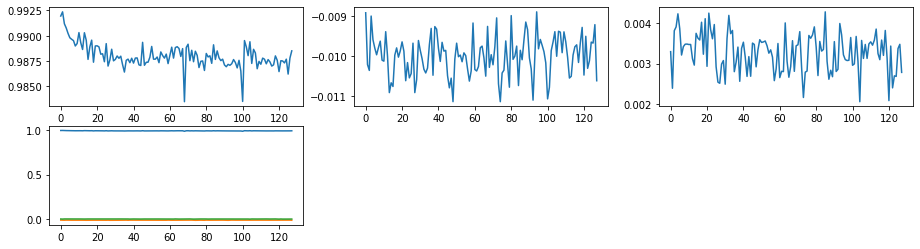

After Filter


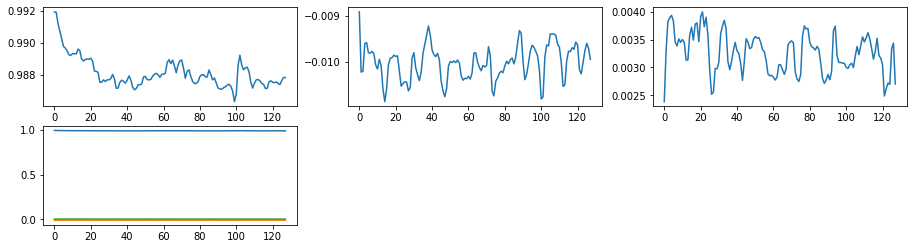

Get from UCI


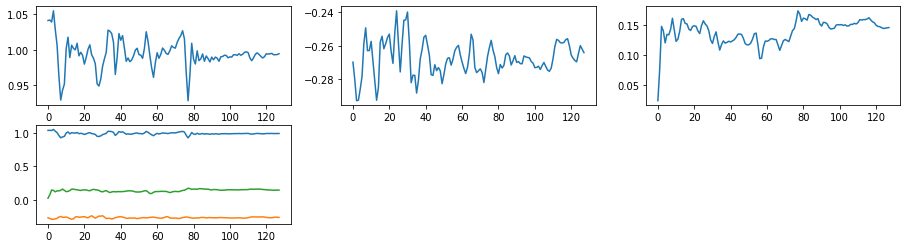

-----------------------------------------------------------

gyro data
Get from smartphone: 


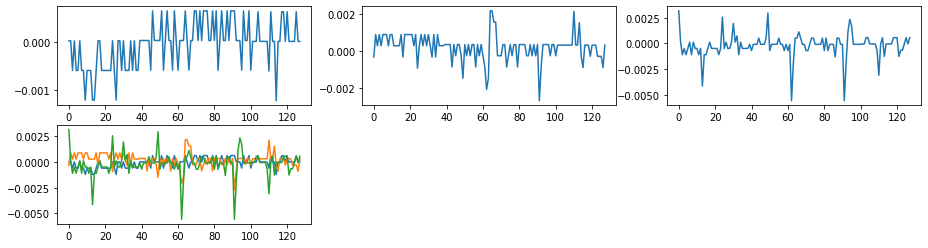

After Filter


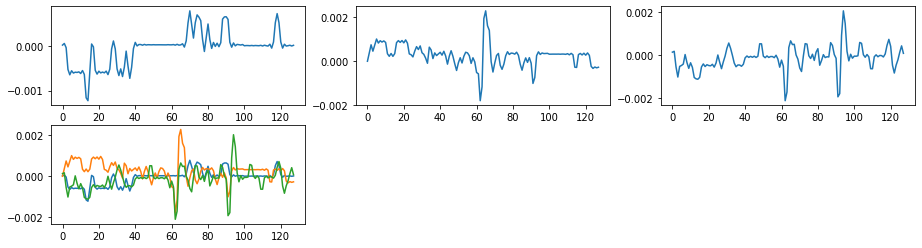

Get from UCI


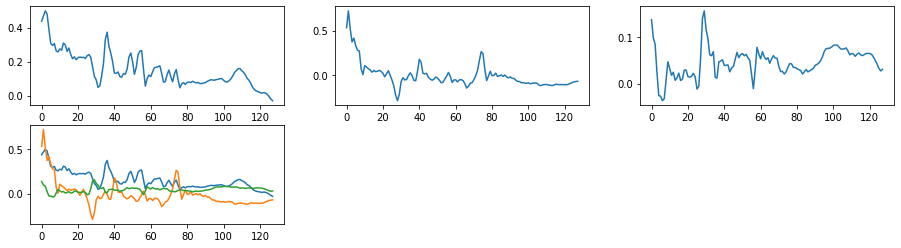

In [22]:
print('acce data')
print('Get from smartphone: ')
show(acce_data)

print('After Filter')
show(total_acce_data)

print('Get from UCI')
data = [total_acc_x[0], total_acc_y[0], total_acc_z[0]]
show(data)

print('-----------------------------------------------------------\n')
print('gyro data')
print('Get from smartphone: ')
show(gyro_data)

print('After Filter')
show(body_gyro_data)

print('Get from UCI')
data = [body_gyro_x[0], body_gyro_y[0], body_gyro_z[0]]
show(data)

## Split in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window)

In [23]:
def _split(samples, data):
    after = []
    for index in range(samples):
        after.append( data[index*64:(index+2)*64] )
    return np.transpose(after, (0,1))
    
def Shape(data, length):
    samples = int(length/64)-1
    return _split(samples, data[0]), _split(samples, data[1]), _split(samples, data[2])

In [24]:
samples = int(data_length/64)-1
print(f'{samples} samples')
total_acc = Shape(total_acce_data, data_length)
body_gyro = Shape(body_gyro_data, data_length)
body_acc = Shape(body_acce_data, data_length)

7 samples


In [25]:
print(len(body_acc))
print(body_acc[0].shape)
print(body_acc[0][0].shape)
print(body_acc[0][0][0])

3
(7, 128)
(128,)
0.00038206236635918156


Get from smartphone: 


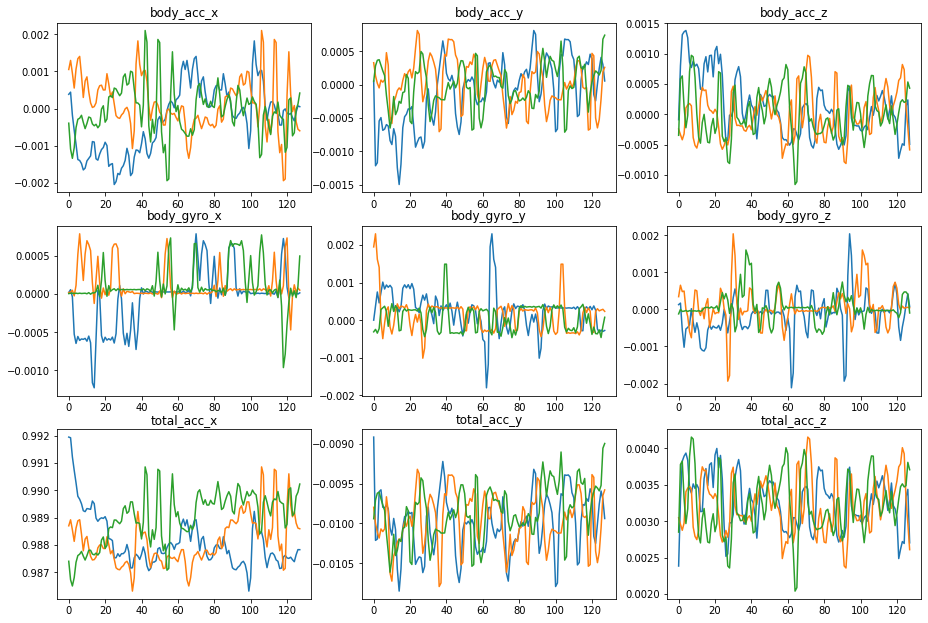

Get from UCI


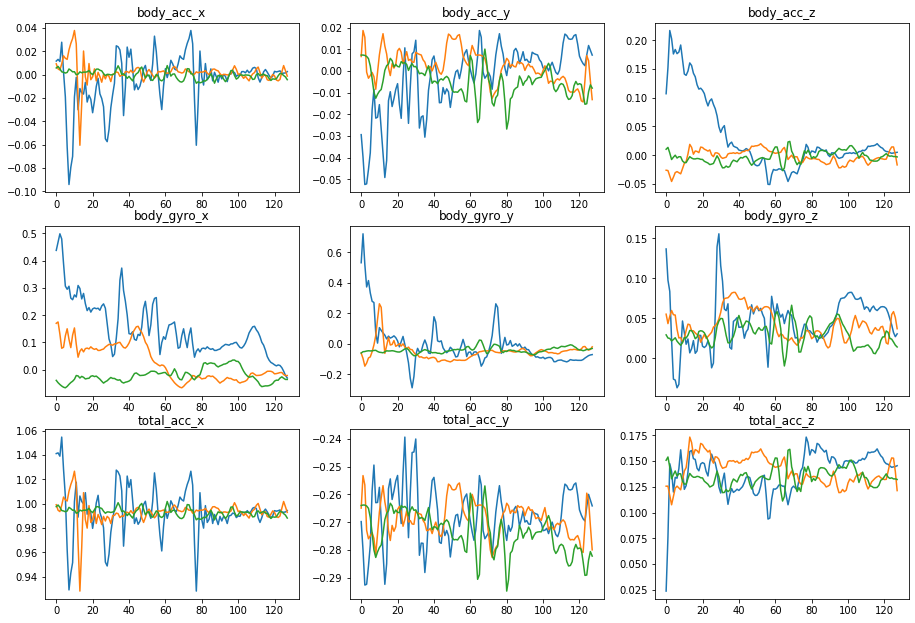

<Figure size 432x288 with 0 Axes>

In [26]:
def oneSample(data):
    plt.subplots_adjust(bottom=1, top=3, left=1, right=3)
    for signal in range(9):
        plt.subplot(331+signal)
        plt.title(SIGNALS[signal])
        plt.plot(data[int(signal/3)][int(signal%3)][0,:])
        plt.plot(data[int(signal/3)][int(signal%3)][1,:])
        plt.plot(data[int(signal/3)][int(signal%3)][2,:])
    plt.show()
    plt.clf()

print('Get from smartphone: ')
phone_data = [body_acc, body_gyro, total_acc]
oneSample(phone_data)


print('Get from UCI')
UCI_data = [[body_acc_x, body_acc_y, body_acc_z],
        [body_gyro_x, body_gyro_y, body_gyro_z],
        [total_acc_x, total_acc_y, total_acc_z]]
oneSample(UCI_data)

## FFT

In [27]:
from scipy.fftpack import fft
def _FFT(data):
    return abs(fft(data))/128
def Time_to_Freq(data):
    new_data = []
    for i in range(len(data)):
        new_data.append( _FFT(data[i]) )
    return new_data

Get from smartphone: 


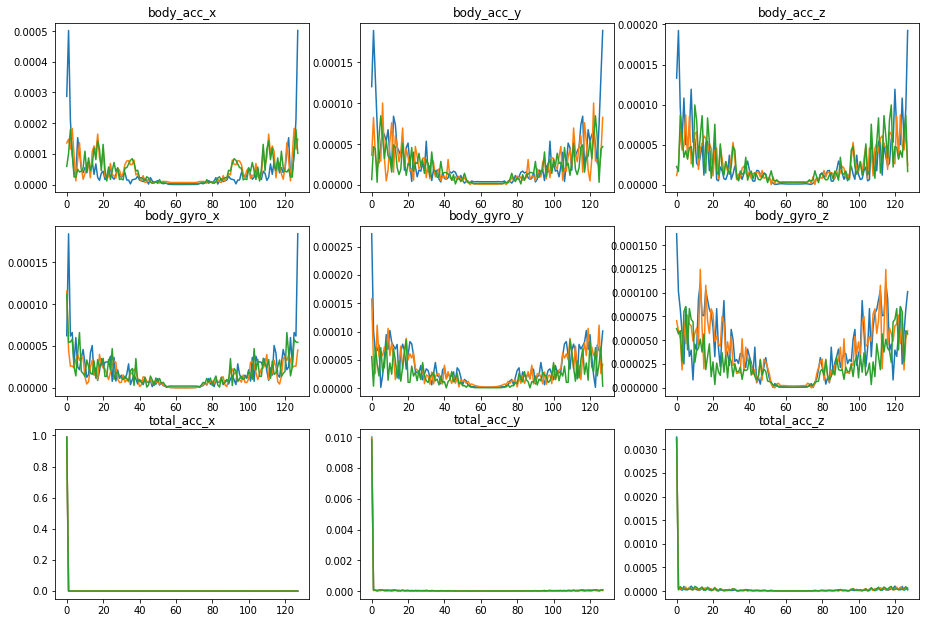

Get from UCI


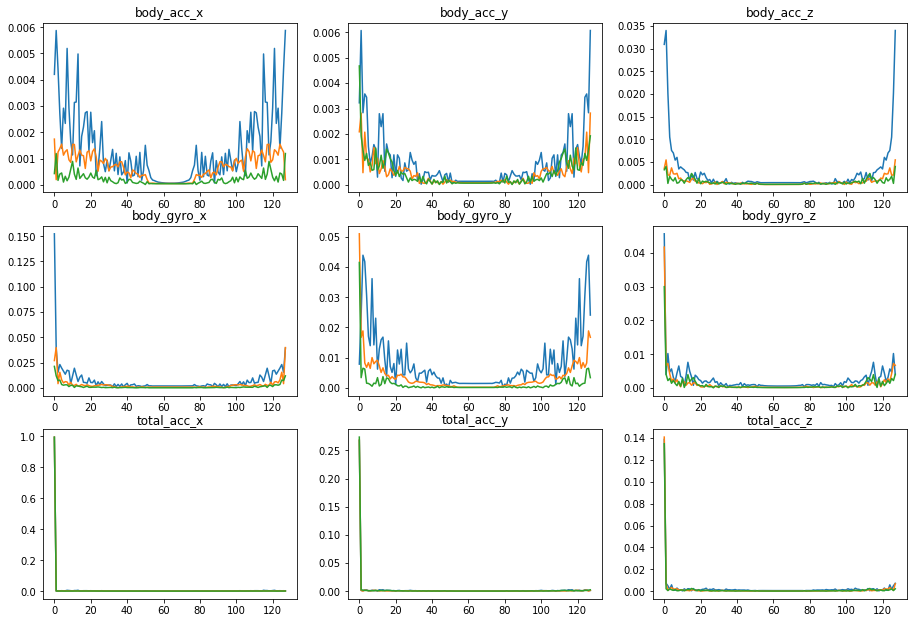

<Figure size 432x288 with 0 Axes>

In [28]:
print('Get from smartphone: ')
fft_phone_data = Time_to_Freq(phone_data)
oneSample(fft_phone_data)

print('Get from UCI')
fft_UCI_data = Time_to_Freq(UCI_data)
oneSample(fft_UCI_data)

## Save data

In [29]:
def WriteSignal(source, activity, samples, body_acce, body_gyro, total_acce):
    document = ''
    if source==1: document = '../Data_smartphone'
    else: document = '../Data_arduino'
    print(f'Saving Data in:')
#     Save data
    index = 0
    for signal in SIGNALS:
        index = index+1
        filename = f'{document}/{signal}.txt'
        print(filename)
        
        # w 建&寫 / w+ 建&寫&讀 / r 讀 / r+ 讀&寫 / a 續寫 / a+續寫&讀 / b 二進位模式
        with open(filename, 'w') as f:
        
            if index<=3: target = body_acce[index-1]
            elif index<=6: target = body_gyro[index-4]
            elif index<=9: target = total_acce[index-7]
            
            np.savetxt(f, target, fmt="%.6e")
            # %.6e 科學記號到小數第6位 / %d 整數 / %.2f 浮點數到小數第2位 / %s 字串
    
#     Save target
    y = np.empty(shape=(samples,1))
    y.fill(activity)
    filename = f'{document}//y.txt'
    with open(filename, 'w') as f:
        np.savetxt(f, y, fmt="%d")
    print(filename)

In [30]:
WriteSignal(Source, Activity, samples, body_acc, body_gyro, total_acc)

Saving Data in:
../Data_smartphone/body_acc_x.txt
../Data_smartphone/body_acc_y.txt
../Data_smartphone/body_acc_z.txt
../Data_smartphone/body_gyro_x.txt
../Data_smartphone/body_gyro_y.txt
../Data_smartphone/body_gyro_z.txt
../Data_smartphone/total_acc_x.txt
../Data_smartphone/total_acc_y.txt
../Data_smartphone/total_acc_z.txt
../Data_smartphone//y.txt
